In [ ]:
  from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata.csv')
table.head()

,Date,IDStation,NameStation,Ammonia,Arsenic,Benzene,Benzo_a_pyrene,Cadmium,CO,Lead,Nikel,NO,NO2,NOx,Ozone,PM10,PM25,Sulfur_dioxide,IDStation.1,reg_Y_nn1_ID,Date.1,IDStation.2,NameStation.1,Wind_speed,Wind_direction,Temperature,Relative_humidity,Global_radiation,Wind_speed_max,Wind_direction_max,Rainfall
0,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,6.2,NaN,NaN,NaN,NaN,0.508333,NaN,NaN,NaN,36.175000,63.570833,5.225000,NaN,45.0,1.829167,677,677,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,0.483454,314.0,2.615278,93.738194,21.268056,2.133333,NaN,7.2
1,2018-01-01T00:00:00Z,681,Moggio,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341667,3.308333,5.075000,66.100000,5.0,4.0,NaN,681,111,2018-01-01T00:00:00Z,111,Cassina Valsassina Moggio,0.300970,65.0,2.095833,74.055556,60.152778,1.939583,144.0,2.4
2,2018-01-01T00:00:00Z,703,Schivenoglia,NaN,NaN,1.0,NaN,NaN,1.159091,NaN,NaN,NaN,25.572727,35.850000,9.281818,44.0,43.0,4.813636,703,671,2018-01-01T00:00:00Z,671,Mantova Tridolino,1.540787,288.0,2.761806,99.475694,14.163194,3.524306,NaN,5.8
3,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.8,NaN,NaN,NaN,NaN,0.375000,NaN,NaN,NaN,35.925000,47.750000,18.441667,32.0,27.0,1.341667,677,677,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.788399,284.0,5.974306,70.609722,72.734028,4.377083,NaN,0.0
4,2018-01-02T00:00:00Z,681,Moggio,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.441667,1.283333,85.891667,3.0,2.0,NaN,681,111,2018-01-02T00:00:00Z,111,Cassina Valsassina Moggio,0.613183,9.0,1.670139,39.194444,68.250000,3.075000,213.0,0.0


In [ ]:
Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:730,:] # we train not using 2020, for now
Moggio.head()


,index,Date,Ammonia,PM10,PM25,Wind_speed,Wind_direction,Temperature,Rainfall
0,1,2018-01-01T00:00:00Z,1.4,5.0,4.0,0.300970,65.0,2.095833,2.4
1,4,2018-01-02T00:00:00Z,1.0,3.0,2.0,0.613183,9.0,1.670139,0.0
2,7,2018-01-03T00:00:00Z,1.0,5.0,5.0,0.539172,28.0,1.972222,0.6
3,10,2018-01-04T00:00:00Z,1.4,6.0,3.0,0.211450,21.0,3.081250,0.0
4,13,2018-01-05T00:00:00Z,1.7,7.0,8.0,0.116953,87.0,3.653472,0.0


In [ ]:
Cremona = table.loc[table.loc[:,"NameStation"]=="Cremona Via Fatebenefratelli",:]
Cremona = Cremona.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Cremona = Cremona.dropna(how="any")
Cremona = Cremona.reset_index()
Cremona = Cremona.iloc[:730,:] # we train not using 2020, for now
Cremona.head()


,index,Date,Ammonia,PM10,PM25,Wind_speed,Wind_direction,Temperature,Rainfall
0,3,2018-01-02T00:00:00Z,1.8,32.0,27.0,1.788399,284.0,5.974306,0.0
1,6,2018-01-03T00:00:00Z,2.7,41.0,35.0,0.244546,345.0,3.490972,0.4
2,9,2018-01-04T00:00:00Z,3.8,45.0,33.0,0.297649,7.0,5.206250,0.0
3,12,2018-01-05T00:00:00Z,7.5,47.0,44.0,0.150277,359.0,4.120833,0.0
4,15,2018-01-06T00:00:00Z,9.3,48.0,44.0,0.746142,294.0,6.281944,1.4


In [ ]:
Schivenoglia = table.loc[table.loc[:,"NameStation"]=="Schivenoglia",:]
Schivenoglia = Schivenoglia.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Schivenoglia = Schivenoglia.dropna(how="any")
Schivenoglia = Schivenoglia.reset_index()
Schivenoglia = Schivenoglia.iloc[:730,:] # we train not using 2020, for now
Schivenoglia.head()


,index,Date,Ammonia,PM10,PM25,Wind_speed,Wind_direction,Temperature,Rainfall
0,8,2018-01-03T00:00:00Z,16.2,39.0,38.0,0.455321,350.0,2.511111,0.0
1,11,2018-01-04T00:00:00Z,17.1,44.0,37.0,0.169860,86.0,5.018056,0.0
2,14,2018-01-05T00:00:00Z,20.5,40.0,39.0,0.349338,268.0,4.311806,0.0
3,17,2018-01-06T00:00:00Z,28.5,86.0,82.0,0.302877,323.0,7.853472,0.0
4,20,2018-01-07T00:00:00Z,21.8,43.0,33.0,1.881774,81.0,9.195139,0.0


In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
def ScaleCity(Table):
 values = Table.iloc[:,2:].values
 # ensure all data is float
 values = values.astype('float32')
 # normalize features
 scaler = MinMaxScaler(feature_range=(0, 1))
 scaled = scaler.fit_transform(values)
 # frame as supervised learning
 n_days = 5
 reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
 # drop columns we don't want to predict (we therefore keep Ammonia)
 reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
 return reframed

In [ ]:
reframedM = ScaleCity(Moggio)
reframedC = ScaleCity(Cremona)
reframedS = ScaleCity(Schivenoglia)
reframed = [reframedM,reframedC, reframedS]

reframedS.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
5,0.031323,0.343750,0.451219,0.076355,0.972067,0.538654,0.0,0.033427,0.395833,0.439024,0.021337,0.234637,0.580189,0.00000,0.041374,0.354167,0.463415,0.055928,0.743017,0.568488,0.00000,0.060075,0.833333,0.987805,0.046974,0.896648,0.627167,0.00000,0.044413,0.385417,0.390244,0.351281,0.220670,0.649397,0.00000,0.029219
6,0.033427,0.395833,0.439024,0.021337,0.234637,0.580189,0.0,0.041374,0.354167,0.463415,0.055928,0.743017,0.568488,0.00000,0.060075,0.833333,0.987805,0.046974,0.896648,0.627167,0.00000,0.044413,0.385417,0.390244,0.351281,0.220670,0.649397,0.00000,0.029219,0.208333,0.231707,0.176137,0.047486,0.000000,0.00431,0.061945
7,0.041374,0.354167,0.463415,0.055928,0.743017,0.568488,0.0,0.060075,0.833333,0.987805,0.046974,0.896648,0.627167,0.00000,0.044413,0.385417,0.390244,0.351281,0.220670,0.649397,0.00000,0.029219,0.208333,0.231707,0.176137,0.047486,0.000000,0.00431,0.061945,0.427083,0.475610,0.144447,0.731844,0.000000,0.00000,0.046985
8,0.060075,0.833333,0.987805,0.046974,0.896648,0.627167,0.0,0.044413,0.385417,0.390244,0.351281,0.220670,0.649397,0.00000,0.029219,0.208333,0.231707,0.176137,0.047486,0.000000,0.00431,0.061945,0.427083,0.475610,0.144447,0.731844,0.000000,0.00000,0.046985,0.322917,0.426829,0.049801,0.882682,0.000000,0.00000,0.038336
9,0.044413,0.385417,0.390244,0.351281,0.220670,0.649397,0.0,0.029219,0.208333,0.231707,0.176137,0.047486,0.000000,0.00431,0.061945,0.427083,0.475610,0.144447,0.731844,0.000000,0.00000,0.046985,0.322917,0.426829,0.049801,0.882682,0.000000,0.00000,0.038336,0.354167,0.536585,0.111996,0.608939,0.000000,0.00000,0.027583


In [ ]:
def ScaleCity(Table):
 values = Table.iloc[:,2:].values
 # ensure all data is float
 values = values.astype('float32')
 # normalize features
 scaler = MinMaxScaler(feature_range=(0, 1))
 scaled = scaler.fit_transform(values)
 # frame as supervised learning
 n_days = 5
 reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
 # drop columns we don't want to predict (we therefore keep Ammonia)
 reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
 # split into train and test sets
 values = reframed.values
 n_features = 7 # number of variables, including the one to be predicted
 n_train_days = 365 # we train using only the first year
 train = values[:n_train_days, :]
 test = values[n_train_days:, :] # we test using all successive years 
 return train, test

In [ ]:
from numpy import dstack
trainM, testM = ScaleCity(Moggio)
trainC, testC = ScaleCity(Cremona)
trainS, testS = ScaleCity(Schivenoglia)
print(testM.shape,testC.shape,testS.shape)
train = dstack((trainM,trainC,trainS))
test = dstack((testM[:287,:],testC[:287,:],testS))
print(train.shape, test.shape)

n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
n_days = 5
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs,:], train[:, -1,:]
test_X, test_y = test[:, :n_obs,:], test[:, -1,:]
print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)


(360, 36) (360, 36) (287, 36)
(365, 36, 3) (287, 36, 3)
(365, 35, 3) (365, 3) (287, 35, 3) (287, 3)


Epoch 1/200
6/6 - 8s - loss: 0.1784 - val_loss: 0.1875 - 8s/epoch - 1s/step
Epoch 2/200
6/6 - 1s - loss: 0.1431 - val_loss: 0.1419 - 537ms/epoch - 89ms/step
Epoch 3/200
6/6 - 1s - loss: 0.1436 - val_loss: 0.1418 - 538ms/epoch - 90ms/step
Epoch 4/200
6/6 - 1s - loss: 0.1478 - val_loss: 0.1410 - 531ms/epoch - 88ms/step
Epoch 5/200
6/6 - 1s - loss: 0.1422 - val_loss: 0.1442 - 516ms/epoch - 86ms/step
Epoch 6/200
6/6 - 1s - loss: 0.1394 - val_loss: 0.1449 - 542ms/epoch - 90ms/step
Epoch 7/200
6/6 - 1s - loss: 0.1379 - val_loss: 0.1426 - 541ms/epoch - 90ms/step
Epoch 8/200
6/6 - 1s - loss: 0.1377 - val_loss: 0.1404 - 514ms/epoch - 86ms/step
Epoch 9/200
6/6 - 1s - loss: 0.1380 - val_loss: 0.1398 - 516ms/epoch - 86ms/step
Epoch 10/200
6/6 - 1s - loss: 0.1371 - val_loss: 0.1410 - 520ms/epoch - 87ms/step
Epoch 11/200
6/6 - 1s - loss: 0.1352 - val_loss: 0.1424 - 511ms/epoch - 85ms/step
Epoch 12/200
6/6 - 1s - loss: 0.1343 - val_loss: 0.1440 - 535ms/epoch - 89ms/step
Epoch 13/200
6/6 - 1s - loss: 

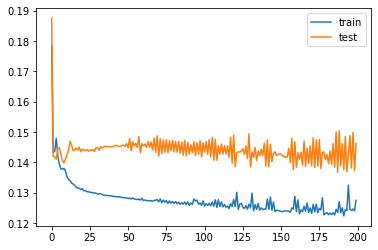

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/50
365/365 - 18s - loss: 0.1227 - val_loss: 0.1437 - 18s/epoch - 48ms/step
Epoch 2/50
365/365 - 11s - loss: 0.1235 - val_loss: 0.1429 - 11s/epoch - 31ms/step
Epoch 3/50
365/365 - 11s - loss: 0.1254 - val_loss: 0.1438 - 11s/epoch - 31ms/step
Epoch 4/50
365/365 - 11s - loss: 0.1258 - val_loss: 0.1428 - 11s/epoch - 31ms/step
Epoch 5/50
365/365 - 11s - loss: 0.1258 - val_loss: 0.1427 - 11s/epoch - 30ms/step
Epoch 6/50
365/365 - 11s - loss: 0.1259 - val_loss: 0.1427 - 11s/epoch - 31ms/step
Epoch 7/50
365/365 - 11s - loss: 0.1266 - val_loss: 0.1421 - 11s/epoch - 29ms/step
Epoch 8/50
365/365 - 11s - loss: 0.1259 - val_loss: 0.1422 - 11s/epoch - 30ms/step
Epoch 9/50
365/365 - 11s - loss: 0.1255 - val_loss: 0.1420 - 11s/epoch - 30ms/step
Epoch 10/50
365/365 - 11s - loss: 0.1263 - val_loss: 0.1413 - 11s/epoch - 30ms/step
Epoch 11/50
365/365 - 11s - loss: 0.1253 - val_loss: 0.1414 - 11s/epoch - 30ms/step
Epoch 12/50
365/365 - 11s - loss: 0.1247 - val_loss: 0.1412 - 11s/epoch - 30ms/step
E

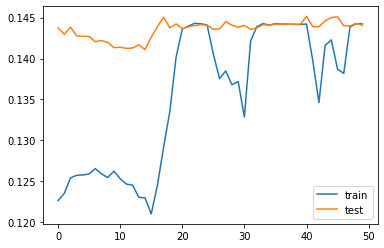

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/200
3/3 - 8s - loss: 0.1569 - val_loss: 0.1662 - 8s/epoch - 3s/step
Epoch 2/200
3/3 - 0s - loss: 0.1379 - val_loss: 0.1437 - 397ms/epoch - 132ms/step
Epoch 3/200
3/3 - 0s - loss: 0.1382 - val_loss: 0.1410 - 397ms/epoch - 132ms/step
Epoch 4/200
3/3 - 0s - loss: 0.1469 - val_loss: 0.1407 - 392ms/epoch - 131ms/step
Epoch 5/200
3/3 - 0s - loss: 0.1454 - val_loss: 0.1401 - 423ms/epoch - 141ms/step
Epoch 6/200
3/3 - 0s - loss: 0.1403 - val_loss: 0.1426 - 404ms/epoch - 135ms/step
Epoch 7/200
3/3 - 0s - loss: 0.1371 - val_loss: 0.1441 - 403ms/epoch - 134ms/step
Epoch 8/200
3/3 - 0s - loss: 0.1352 - val_loss: 0.1428 - 404ms/epoch - 135ms/step
Epoch 9/200
3/3 - 0s - loss: 0.1343 - val_loss: 0.1403 - 398ms/epoch - 133ms/step
Epoch 10/200
3/3 - 0s - loss: 0.1347 - val_loss: 0.1387 - 404ms/epoch - 135ms/step
Epoch 11/200
3/3 - 0s - loss: 0.1355 - val_loss: 0.1379 - 407ms/epoch - 136ms/step
Epoch 12/200
3/3 - 0s - loss: 0.1352 - val_loss: 0.1380 - 405ms/epoch - 135ms/step
Epoch 13/200
3/3 - 

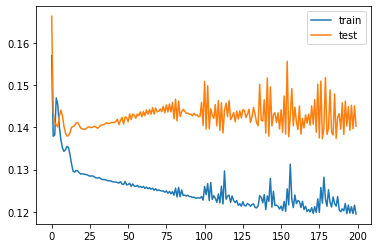

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=200, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()